# Prompt Chaining: Langgraph 와 Langfuse 로 Amazon Bedrock 시작하기

이 노트북은 [Langfuse](https://langfuse.com/) 를 사용하여 Amazonb Bedrock 의 LLM 을 사용하는 방법을 
가이드하는 노트북 입니다.

구체적으로 LangGraph 로 Prompt Chaining 하는 방법을 배웁니다.

### 참조
- [LangGraph: Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining)
- What is chat messages, chat model, binding tools? --> [Build a simple graph with nodes, normal edges, and conditional edges.](https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb)




---

## 1. 선수 사항: 
### 1.1 Langfuse 사용 환경 및 콘다 가상 환경 생성
- 아래의 설치 가이드에 따라 먼저 진행 해주세요.
    - [환경 설치 가이드: ](https://github.com/aws-samples/aws-ai-ml-workshop-kr/tree/master/genai/aws-gen-ai-kr/20_applications/19_agentic_rag)


### 1.2. Key 정보를 저장하는 env 파일 생성
-  ../../.env 파일을 생성하고 아래의 내용을 작성, 19_agentic_rag 폴더 아래에 생성 하시면 됩니다.
    ```
    LANGFUSE_SECRET_KEY=<secret key>
    LANGFUSE_PUBLIC_KEY=<public key>
    LANGFUSE_HOST=<host url>
    ```    

## 2. 환경 설정

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)

from utils.langgraph_util import ( 
    show_graph_dag,
)

python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse is added
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse/03_langgraph', '/home/sagemaker-user/.conda/envs/langgraph/lib/python310.zip', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse']


## 3. 환경 변수 로딩
아래와 같은 환경 변수를 로딩 함.
```
LANGSMITH_TRACING=true
LANGSMITH_API_KEY=your_langsmith_api_key
OPENAI_API_KEY=your_openai_api_key
```

In [2]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("../../.env")



True

## 4. langfuse_handler 핸들러 작성하기

In [3]:
from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

### langfuse endpoint 에 인증 해보기

In [4]:
# connection test
langfuse_handler.auth_check()

True

## 5. LangChain 인터페이스의 Bedrock 모델 생성
- LangChain 개발자 가이드: [ChatBedrock](https://python.langchain.com/docs/integrations/chat/bedrock/)

]

In [5]:
from langchain_aws import ChatBedrockConverse

# model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
model_id = "us.amazon.nova-pro-v1:0"

llm = ChatBedrockConverse(
    model= model_id,
    temperature=0,
    max_tokens=None,
    # other params...
)

llm

ChatBedrockConverse(client=<botocore.client.BedrockRuntime object at 0x7fb1460b80d0>, model_id='us.amazon.nova-pro-v1:0', temperature=0.0, region_name='us-east-1', provider='amazon', supports_tool_choice_values=['auto'])

## 6. Grpah 정의 하기

### State 정의

In [6]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

### Node 및 분기  함수 정의

In [7]:
# Node: 첫번째 농담 생성 
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']} in Korean")
    return {"joke": msg.content}

In [8]:
# 분기문: 농담의 결정적 부분이 있는지 확인. ! , ? 의 유무로 판단
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

In [9]:
# Node: 특정 단어를 제공하여, 조금 더 농담을 재미있게 생성
def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay in Korean: {state['joke']}")
    return {"improved_joke": msg.content}

In [10]:
# Node: 제공 받은 농담을 한번더 "놀라운 반전" 을 생성 합니다.
def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']} in Korean")
    return {"final_joke": msg.content}

### 그래프 구조 만들기

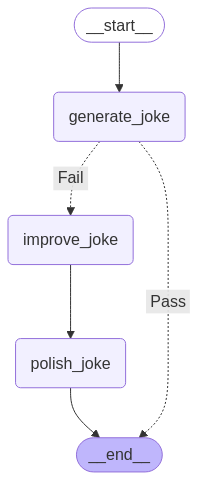

In [11]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

### Graph 호출

In [12]:
# Invoke
state = chain.invoke({"topic": "고양이"},
    config={
            "callbacks": [langfuse_handler],
        }
)

### 최종 State 값 보기
- 각 Node 에서 State Class 의 변수에 값을 할당함.

In [13]:
state

{'topic': '고양이',
 'joke': '물론입니다! 여기 고양이에 관한 짧은 농담이 있습니다:\n\n---\n\n오늘 고양이가 컴퓨터 앞에 앉아서 말했어요: "야, 내가 유튜브에 고양이 동영상을 올리려고 하는데, 너희들 조금 재미있게 놀아줘!" \n\n다른 고양이들이 말했죠: "왜? 너한테 키보드 치는 건 배웠어?"\n\n---\n\n웃기셨나요? 고양이들은 정말 컴퓨터를 잘 다루지 못하죠!',
 'improved_joke': '물론입니다! 여기 고양이에 관한 짧은 농담에 좀 더 재미있는 한국어 언어 유희를 추가한 버전이 있습니다:\n\n---\n\n오늘 고양이가 컴퓨터 앞에 앉아서 말했어요: "야, 내가 유튜브에 고양이 동영상을 올리려고 하는데, 너희들 조금 재미있게 놀아줘! 그럼 너희도 조금 \'유튜브 스타\'가 될 수 있어!"\n\n다른 고양이들이 말했죠: "왜? 너한테 키보드 치는 건 배웠어? 아니면 그냥 냥냥이 특유의 \'냥타스틱\' 댄스만 춰?"\n\n---\n\n웃기셨나요? 고양이들은 정말 컴퓨터를 잘 다루지 못하지만, 냥냥이들만의 \'냥타스틱\' 매력으로 우리를 웃게 만들죠!',
 'final_joke': '물론입니다! 여기 고양이에 관한 짧은 농담에 좀 더 재미있는 한국어 언어 유희와 놀라운 반전을 추가한 버전이 있습니다:\n\n---\n\n오늘 고양이가 컴퓨터 앞에 앉아서 말했어요: "야, 내가 유튜브에 고양이 동영상을 올리려고 하는데, 너희들 조금 재미있게 놀아줘! 그럼 너희도 조금 \'유튜브 스타\'가 될 수 있어!"\n\n다른 고양이들이 말했죠: "왜? 너한테 키보드 치는 건 배웠어? 아니면 그냥 냥냥이 특유의 \'냥타스틱\' 댄스만 춰?"\n\n그때 갑자기 컴퓨터 화면이 깜빡였고, 모니터에서 뜻밖에 인간의 얼굴이 나타났어요. 인간은 말했죠: "사실 난 너희 고양이들의 재미있는 모습을 찍으려고 숨어 있었는데... 너희들 덕분에 내가 유튜브 스타가 될 뻔했어!"\n\n고양이들은 당황해하며 서로 속삭였어요: "얘들아, 우리가 너무 재

### State 값 흐름에 따라 출력

In [14]:

print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
물론입니다! 여기 고양이에 관한 짧은 농담이 있습니다:

---

오늘 고양이가 컴퓨터 앞에 앉아서 말했어요: "야, 내가 유튜브에 고양이 동영상을 올리려고 하는데, 너희들 조금 재미있게 놀아줘!" 

다른 고양이들이 말했죠: "왜? 너한테 키보드 치는 건 배웠어?"

---

웃기셨나요? 고양이들은 정말 컴퓨터를 잘 다루지 못하죠!

--- --- ---

Improved joke:
물론입니다! 여기 고양이에 관한 짧은 농담에 좀 더 재미있는 한국어 언어 유희를 추가한 버전이 있습니다:

---

오늘 고양이가 컴퓨터 앞에 앉아서 말했어요: "야, 내가 유튜브에 고양이 동영상을 올리려고 하는데, 너희들 조금 재미있게 놀아줘! 그럼 너희도 조금 '유튜브 스타'가 될 수 있어!"

다른 고양이들이 말했죠: "왜? 너한테 키보드 치는 건 배웠어? 아니면 그냥 냥냥이 특유의 '냥타스틱' 댄스만 춰?"

---

웃기셨나요? 고양이들은 정말 컴퓨터를 잘 다루지 못하지만, 냥냥이들만의 '냥타스틱' 매력으로 우리를 웃게 만들죠!

--- --- ---

Final joke:
물론입니다! 여기 고양이에 관한 짧은 농담에 좀 더 재미있는 한국어 언어 유희와 놀라운 반전을 추가한 버전이 있습니다:

---

오늘 고양이가 컴퓨터 앞에 앉아서 말했어요: "야, 내가 유튜브에 고양이 동영상을 올리려고 하는데, 너희들 조금 재미있게 놀아줘! 그럼 너희도 조금 '유튜브 스타'가 될 수 있어!"

다른 고양이들이 말했죠: "왜? 너한테 키보드 치는 건 배웠어? 아니면 그냥 냥냥이 특유의 '냥타스틱' 댄스만 춰?"

그때 갑자기 컴퓨터 화면이 깜빡였고, 모니터에서 뜻밖에 인간의 얼굴이 나타났어요. 인간은 말했죠: "사실 난 너희 고양이들의 재미있는 모습을 찍으려고 숨어 있었는데... 너희들 덕분에 내가 유튜브 스타가 될 뻔했어!"

고양이들은 당황해하며 서로 속삭였어요: "얘들아, 우리가 너무 재미있게 놀다가 인간을 유튜브 스타로 만들 뻔했어!"

---

어떠

## 7. Langfuse Tracing Output
![joke_graph.png](img/joke_graph.png)